In [3]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

COLUMNS = ['Date','Total_Cases','New_Daily_Cases','New_Daily_Deaths','Total_Deaths','Total_Recoveries']

In [2]:
import requests
import sys
import csv
import datetime

def generate_csv(code):
    url = "https://thevirustracker.com/free-api?countryTimeline=" + code

    r = requests.get(url, headers={"User-Agent": "XY"})

    data = r.json()
    keys = data['timelineitems'][0].keys()
    length = len(keys)
    name = "covid" + code + ".csv"
    with open(name, 'w', newline='') as file:
                writer = csv.writer(file)
                for key in keys:
                    if length > 2:
                        row = []
                        x = datetime.datetime.strptime(key, '%m/%d/%Y')
                        xn = x - datetime.timedelta(days=1)
                        date = xn.strftime("%m/%d/%Y")
                        row.append(date)
                        row.append(data['timelineitems'][0][key]['total_cases'])
                        row.append(data['timelineitems'][0][key]['new_daily_cases'])
                        row.append(data['timelineitems'][0][key]['new_daily_deaths'])
                        row.append(data['timelineitems'][0][key]['total_deaths'])
                        row.append(data['timelineitems'][0][key]['total_recoveries'])
                        writer.writerow(row)
                        length-=1

In [3]:
def create_dataset(siglas):
    result = pd.DataFrame()
    for i in siglas:
        t = generate_csv(i)
        t_d = pd.read_csv('covid'+i+'.csv')
        tmp = [j+i for j in COLUMNS[1:]]
        tmp.insert(0,'Date')
        t_d.columns = tmp
        t_d.set_index('Date', inplace=True, drop=True)
        result = pd.concat([result,t_d], axis=1, sort=True)    

In [63]:
generate_csv("PT")
generate_csv("IT")
generate_csv("ES")

In [4]:
dataPT = pd.read_csv('covidPT.csv')
tmp = [i+"PT" for i in COLUMNS[1:]]
tmp.insert(0,'Date')
dataPT.columns = tmp
dataPT.set_index('Date', inplace=True, drop=True)
dataPT.head()

,Total_CasesPT,New_Daily_CasesPT,New_Daily_DeathsPT,Total_DeathsPT,Total_RecoveriesPT
Date,,,,,
03/01/2020,2,2,0,0,0
03/02/2020,2,0,0,0,0
03/03/2020,5,3,0,0,0
03/04/2020,9,4,0,0,0
03/05/2020,13,4,0,0,0


In [5]:
dataES = pd.read_csv('covidES.csv')
tmp = [i+"ES" for i in COLUMNS[1:]]
tmp.insert(0,'Date')
dataES.columns = tmp
dataES.set_index('Date', inplace=True, drop=True)

dataIT = pd.read_csv('covidIT.csv')
tmp = [i+"IT" for i in COLUMNS[1:]]
tmp.insert(0,'Date')
dataIT.columns = tmp
dataIT.set_index('Date', inplace=True, drop=True)
dataIT.tail()

,Total_CasesIT,New_Daily_CasesIT,New_Daily_DeathsIT,Total_DeathsIT,Total_RecoveriesIT
Date,,,,,
03/24/2020,69176,5249,743,6820,8326
03/26/2020,80589,11413,1395,8215,10361
03/27/2020,86498,5909,919,9134,10950
03/28/2020,92472,5974,889,10023,12384
03/29/2020,97689,5217,756,10779,13030


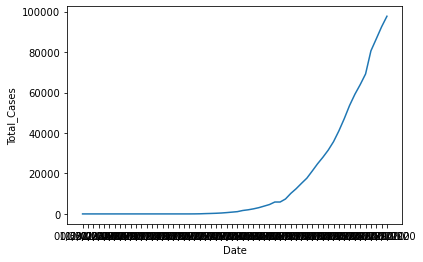

In [7]:
# Visualization
X = dataPT.drop(columns=['New_Daily_Deaths','Date'], axis=0)
y = dataPT['New_Daily_Deaths']

time = dataIT.drop(columns=['New_Daily_Deaths','New_Daily_Cases','Total_Deaths','Total_Recoveries'], axis=0)
time.head()
sb.lineplot('Date','Total_Cases',data=time)

In [6]:
def create_dataset_v2(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
from sklearn.preprocessing import MinMaxScaler
values = dataIT[['Total_CasesIT']].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

trainX, trainY = create_dataset_v2(train, 5)
testX, testY = create_dataset_v2(test, 5)

print(trainX.shape)

trainX = np.reshape(trainX, (trainX.shape[0], 5, 1))
testX = np.reshape(testX, (testX.shape[0], 5, 1))

46 12
(41, 5)


In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model_ls = Sequential()
model_ls.add(LSTM(18,input_shape=(trainX.shape[1],trainX.shape[2])))
model_ls.add(Dense(6, activation='relu'))
model_ls.add(Dense(1, activation='relu'))
model_ls.compile(loss='mean_squared_error', optimizer='adam')
history = model_ls.fit(trainX, trainY, epochs=100, batch_size=32, validation_data=(testX,testY), shuffle=False)

Train on 41 samples, validate on 7 samples
Epoch 1/100
41/41 [==============================] - 1s 33ms/sample - loss: 0.0068 - val_loss: 0.6332
Epoch 2/100
41/41 [==============================] - 0s 310us/sample - loss: 0.0066 - val_loss: 0.6262
Epoch 3/100
41/41 [==============================] - 0s 333us/sample - loss: 0.0064 - val_loss: 0.6190
Epoch 4/100
41/41 [==============================] - 0s 375us/sample - loss: 0.0061 - val_loss: 0.6117
Epoch 5/100
41/41 [==============================] - 0s 345us/sample - loss: 0.0059 - val_loss: 0.6044
Epoch 6/100
41/41 [==============================] - 0s 386us/sample - loss: 0.0058 - val_loss: 0.5970
Epoch 7/100
41/41 [==============================] - 0s 375us/sample - loss: 0.0056 - val_loss: 0.5897
Epoch 8/100
41/41 [==============================] - 0s 376us/sample - loss: 0.0054 - val_loss: 0.5824
Epoch 9/100
41/41 [==============================] - 0s 354us/sample - loss: 0.0053 - val_loss: 0.5751
Epoch 10/100
41/41 [===========

41/41 [==============================] - 0s 349us/sample - loss: 0.0046 - val_loss: 0.1936
Epoch 80/100
41/41 [==============================] - 0s 337us/sample - loss: 0.0046 - val_loss: 0.1872
Epoch 81/100
41/41 [==============================] - 0s 381us/sample - loss: 0.0045 - val_loss: 0.1807
Epoch 82/100
41/41 [==============================] - 0s 347us/sample - loss: 0.0044 - val_loss: 0.1742
Epoch 83/100
41/41 [==============================] - 0s 345us/sample - loss: 0.0044 - val_loss: 0.1676
Epoch 84/100
41/41 [==============================] - 0s 337us/sample - loss: 0.0043 - val_loss: 0.1609
Epoch 85/100
41/41 [==============================] - 0s 353us/sample - loss: 0.0043 - val_loss: 0.1543
Epoch 86/100
41/41 [==============================] - 0s 364us/sample - loss: 0.0042 - val_loss: 0.1475
Epoch 87/100
41/41 [==============================] - 0s 332us/sample - loss: 0.0041 - val_loss: 0.1408
Epoch 88/100
41/41 [==============================] - 0s 398us/sample - loss:

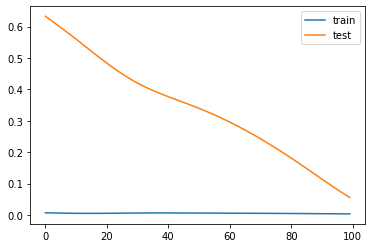

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [19]:
predictions = model_ls.predict(testX)
print(scaler.inverse_transform(predictions))

[[39628.58 ]
 [44803.42 ]
 [50227.754]
 [55578.277]
 [61252.895]
 [66529.46 ]
 [71681.29 ]]


In [7]:
def prepare_dataset(dataset, timesteps=5, multisteps=1):
    data = dataset.values
    X=[]
    y=[]
    for i in range(dataset.shape[0] - (timesteps + multisteps)):
        input_index = i + timesteps
        label_index = input_index + multisteps
        X.append(data[i:input_index,:])
        y.append(data[input_index:label_index,0])
    return X,y

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Prepare data from LSTM
data_lstm = dataIT.drop(columns=['New_Daily_CasesIT','New_Daily_DeathsIT','Total_DeathsIT','Total_RecoveriesIT'], axis=0)
#data_lstm['Date'] = range(0,len(dataIT_dates))
#print(data_lstm.head)

scaler = MinMaxScaler((-1,1))
data_lstm['Total_CasesIT'] = scaler.fit_transform(np.array(data_lstm['Total_CasesIT']).reshape(-1,1))
#print(data_lstm)
X, y = prepare_dataset(data_lstm)

X_reshaped = np.array(X).reshape((52,5,1))
print(X_reshaped)

[[[-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]]

 [[-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]]

 [[-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]]

 [[-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-0.99997953]]

 [[-1.        ]
  [-1.        ]
  [-1.        ]
  [-0.99997953]
  [-0.99997953]]

 [[-1.        ]
  [-1.        ]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]]

 [[-1.        ]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]]

 [[-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]]

 [[-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]]

 [[-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]]

 [[-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]]

 [[-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]]

 [[-0.99997953]


In [9]:
train_size = int(len(X_reshaped) * 0.66)
train_x, test_x = X_reshaped[0:train_size], X_reshaped[train_size:len(X_reshaped)]
train_y, test_y = y[0:train_size], y[train_size:len(y)]

In [10]:
# LSTM
from tensorflow.keras import Sequential, layers, optimizers, losses

TIMESTAMPS = 5
FEATURES   = 1
BATCH_SIZE = 52


model = Sequential()
model.add(layers.LSTM(8,stateful=True,
                      batch_input_shape=(1,TIMESTAMPS,FEATURES)))
model.add(layers.Dense(FEATURES,activation='relu'))

model.compile(
    loss="mean_squared_error",
    optimizer= optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
for i in range(100):
    model.fit(train_x,train_y, shuffle=False, batch_size=1, epochs=1, verbose=2)
    model.reset_states()

ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), for inputs ['dense'] but instead got the following list of 34 arrays: [array([[-1.]]), array([[-1.]]), array([[-0.99997953]]), array([[-0.99997953]]), array([[-0.99997953]]), array([[-0.99997953]]), array([[-0.99997953]]), array([[-0.99997953]]), array([[-0.99997953]]),...

In [ ]:
for i in range(len(test)):
        # make one-step forecast
        Xx, yy = test[i, 0:-1], test[i, -1]
        yhat = model.predict(X, batch_size=BATCH_SIZE)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        # report performance
    rmse = sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

In [137]:
# Linear Regression
data_reg = dataIT.drop(columns=['New_Daily_CasesIT','New_Daily_DeathsIT','Total_DeathsIT','Total_RecoveriesIT'], axis=0)
data_reg = data_reg.shift(5)
data_reg.head()


#from sklearn.linear_model import LinearRegression
#model_death = LinearRegression()
#model_death.fit(X,y)
#new_y = model.predict()

,Total_CasesIT
Date,
01/30/2020,NaN
01/31/2020,NaN
02/01/2020,NaN
02/02/2020,NaN
02/03/2020,NaN


            Total_CasesIT
Date                     
01/30/2020              2
01/31/2020              2
02/01/2020              2
02/02/2020              2
02/03/2020              2


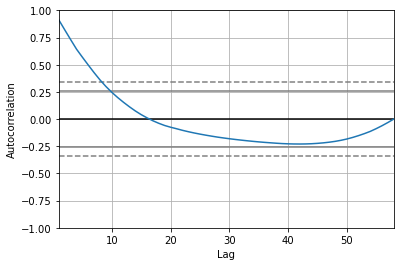

In [100]:
data_arima = dataIT.drop(columns=['New_Daily_CasesIT','New_Daily_DeathsIT','Total_DeathsIT','Total_RecoveriesIT'], axis=0)
print(data_arima.head())
pd.plotting.autocorrelation_plot(data_arima)
plt.show()

/home/msi-gtfo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   58
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -474.123
Date:                Wed, 08 Apr 2020   AIC                            960.245
Time:                        17:20:16   BIC                            972.504
Sample:                             0   HQIC                           965.009
                                 - 58                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4117      0.178      2.307      0.021       0.062       0.761
ar.L2          0.1477      0.213      0.692      0.489      -0.270       0.566
ar.L3         -0.0123      0.281     -0.044      0.9

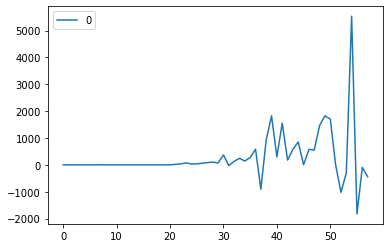

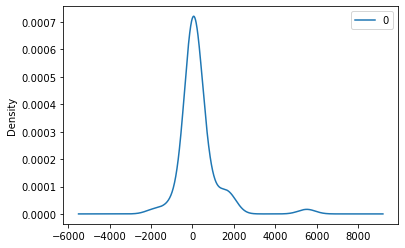

                  0
count  5.800000e+01
mean   2.666580e+02
std    9.313092e+02
min   -1.827330e+03
25%   -1.333577e-10
50%    2.219422e+00
75%    2.627018e+02
max    5.530686e+03


In [63]:
# ARIMA Model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data_arima.values, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

/home/msi-gtfo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


predicted=7317.036471, expected=7375.000000
predicted=7274.677186, expected=10149.000000
predicted=10862.373943, expected=12462.000000
predicted=14172.640273, expected=15113.000000
predicted=18681.407664, expected=17660.000000
predicted=19993.123086, expected=21157.000000
predicted=24366.566420, expected=24747.000000
predicted=28255.865012, expected=27980.000000
predicted=31388.745165, expected=31506.000000
predicted=35144.770998, expected=35713.000000
predicted=39687.992991, expected=41035.000000
predicted=46164.923195, expected=47021.000000
predicted=53183.372594, expected=53578.000000
predicted=60548.350987, expected=59138.000000
predicted=64777.484488, expected=63927.000000
predicted=68725.432063, expected=69176.000000
predicted=74510.469944, expected=80589.000000
predicted=93263.944466, expected=86498.000000
predicted=92430.138284, expected=92472.000000
predicted=99070.969065, expected=97689.000000
Test MSE: 5246004.650


/home/msi-gtfo/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


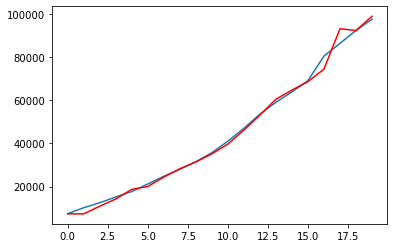

In [64]:
from sklearn.metrics import mean_squared_error

X = data_arima.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [55]:
import datetime
#data_arima.head()
data_arima.reset_index(inplace=True)
xn = datetime.datetime.strptime(data_arima.iloc[-1]['Date'], '%m/%d/%Y') + datetime.timedelta(days=5)
xn.strftime("%m/%d/%Y")

'04/03/2020'

In [105]:
def predict_with_arima(data, days=5, y='Total_Cases', code='IT'):
    history = [x for x in data.values]
    news = []
    data_mod = data.reset_index()
    for i in range(days):
        model = ARIMA(history, order=(4,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        history.append(np.array([round(yhat)]))
        
        xn = datetime.datetime.strptime(data_mod.iloc[-1]['Date'], '%m/%d/%Y') + datetime.timedelta(days=i+1)
        
        news.append(
            pd.Series([xn.strftime("%m/%d/%Y"), yhat], index=data_mod.columns )
        )
        
    data_mod = data_mod.append(news)
    data_mod.set_index('Date', inplace=True, drop=True)
    return history, data_mod

In [108]:
forecasted_data, dataset = predict_with_arima(data_arima, days=10)
#plt.figure(figsize=(15, 5))
#plt.plot(data_arima.values, color='blue')
#plt.plot(forecasted_data, color='red')
print(forecasted_data[-10:])
print(dataset.tail(15))

/home/msi-gtfo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/msi-gtfo/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[array([106133.]), array([112879.]), array([119503.]), array([125410.]), array([132679.]), array([139504.]), array([146307.]), array([152656.]), array([159523.]), array([166297.])]
            Total_CasesIT
Date                     
03/24/2020   69176.000000
03/26/2020   80589.000000
03/27/2020   86498.000000
03/28/2020   92472.000000
03/29/2020   97689.000000
03/30/2020  106132.942611
03/31/2020  112878.659093
04/01/2020  119502.912104
04/02/2020  125409.758432
04/03/2020  132678.525746
04/04/2020  139504.062387
04/05/2020  146307.097063
04/06/2020  152655.636801
04/07/2020  159523.378283
04/08/2020  166297.054616


In [107]:
print(data_arima.tail())

            Total_CasesIT
Date                     
03/24/2020          69176
03/26/2020          80589
03/27/2020          86498
03/28/2020          92472
03/29/2020          97689


predicted=5825.441958, expected=7375.000000
predicted=7065.088392, expected=10149.000000
predicted=9532.217678, expected=12462.000000
predicted=11876.043536, expected=15113.000000
predicted=14465.608707, expected=17660.000000
predicted=17021.121741, expected=21157.000000
predicted=20329.824348, expected=24747.000000
predicted=23863.564870, expected=27980.000000
predicted=27156.712974, expected=31506.000000
predicted=30636.142595, expected=35713.000000
predicted=34697.628519, expected=41035.000000
predicted=39767.525704, expected=47021.000000
predicted=45570.305141, expected=53578.000000
predicted=51976.461028, expected=59138.000000
predicted=57705.692206, expected=63927.000000
predicted=62682.738441, expected=69176.000000
predicted=67877.347688, expected=80589.000000
predicted=78046.669538, expected=86498.000000
predicted=84807.733908, expected=92472.000000
predicted=90939.146782, expected=97689.000000


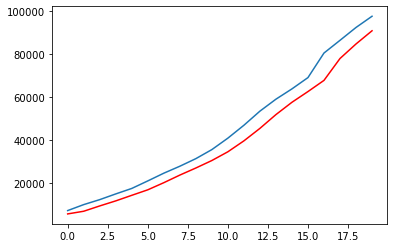

In [134]:
# Exponential Smoothening
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

X = data_arima.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = SimpleExpSmoothing(history)
	model_fit = model.fit(smoothing_level=0.8)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            Total_CasesIT
Date                     
01/30/2020       2.000000
01/31/2020       2.000000
02/01/2020       2.000000
02/02/2020       2.000000
02/03/2020       2.000000
...                   ...
04/04/2020  130075.074160
04/05/2020  135726.799266
04/06/2020  141281.556793
04/07/2020  146452.931932
04/08/2020  151652.852156

[68 rows x 1 columns]
            ds      y
53  03/24/2020  69176
54  03/26/2020  80589
55  03/27/2020  86498
56  03/28/2020  92472
57  03/29/2020  97689
            Total_CasesIT
Date                     
03/24/2020          69176
03/26/2020          80589
03/27/2020          86498
03/28/2020          92472
03/29/2020          97689


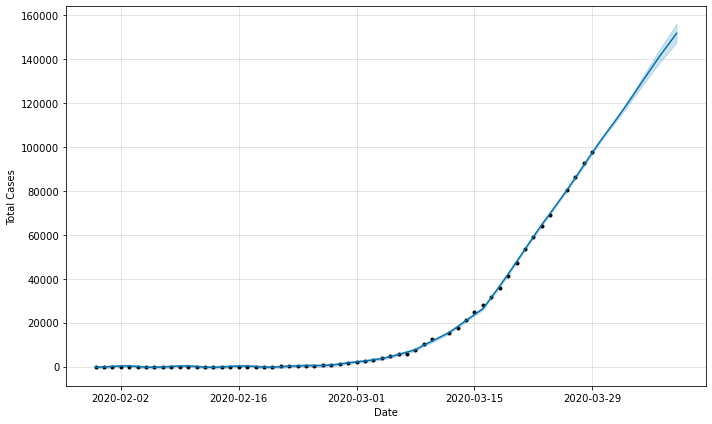

In [117]:
#PROPHET
from fbprophet import Prophet

tmp = dataIT[['Total_CasesIT']]
data_prophet = tmp.reset_index()
data_prophet = data_prophet.rename(columns={'Date': 'ds', 'Total_CasesIT': 'y'})

model_prophet = Prophet(changepoint_prior_scale=0.1)
model_prophet.fit(data_prophet)

data_prophet_forecast = model_prophet.make_future_dataframe(periods=10)
data_prophet_forecast = model_prophet.predict(data_prophet_forecast)

model_prophet.plot(data_prophet_forecast, xlabel = 'Date', ylabel = 'Total Cases')

dt = data_prophet_forecast[['ds','yhat']][-10:]
dt = dt.rename(columns={'ds': 'Date', 'yhat': 'Total_CasesIT'})
dt['Date'] = dt['Date'].dt.strftime('%m/%d/%Y')
dt.set_index('Date', inplace=True, drop=True)

tmpdata = dataIT.drop(columns=['New_Daily_CasesIT','New_Daily_DeathsIT','Total_DeathsIT','Total_RecoveriesIT'], axis=0)
tmpdata = tmpdata.append(dt)
print(tmpdata)
print(data_prophet.tail())
print(tmp.tail())